## Data Exploration

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import ER_multiclass as ER

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# load data
df = pd.read_csv('drug_data2.txt')
df.head()

,Name,Line,Treatment,Concentration,Day,boutd,sleepd,boutn,sleepn,wakeact,sleeplat,Sex
0,51_1_900,900,Chlorpromazine_Sonazine_,1,1,17,162,13,495,2.14559,73.0,Female
1,51_1_900,900,Chlorpromazine_Sonazine_,1,2,14,120,4,562,1.68865,98.0,Female
2,51_1_900,900,Chlorpromazine_Sonazine_,1,3,9,94,2,594,2.06516,36.0,Female
3,51_1_900,900,Chlorpromazine_Sonazine_,1,4,12,108,12,538,1.75441,6.0,Female
4,51_1_900,900,Chlorpromazine_Sonazine_,1,5,18,194,6,658,1.78231,55.0,Female


In [4]:
df2 = df[['Sex','Treatment','Concentration','Day','wakeact']].copy()

In [5]:
df3 = np.array(df2)

In [6]:
df3.shape

(3595, 5)

In [7]:
# select only day = 5
df = df3[df3[:,3] ==5]

In [8]:
df.shape

(719, 5)

In [9]:
# features:
X = df[:,0:3]
X.shape

(719, 3)

In [10]:
np.unique(X[:,0],return_counts=True)

(array(['Female', 'Male'], dtype=object), array([365, 354]))

In [11]:
np.unique(X[:,1],return_counts=True)

(array(['Chlorpromazine_Sonazine_', 'Pizotifen_malate',
        'Sodium_salicylate', 'Trifluoperazine2HCl_'], dtype=object),
 array([172, 184, 180, 183]))

In [12]:
np.unique(X[:,2],return_counts=True)

(array([1, 2, 3, 4], dtype=object), array([160, 184, 187, 188]))

In [13]:
y = df[:,4].astype(float)

In [14]:
y.min()

0.0

In [15]:
bins = np.linspace(min(y), max(y),10, endpoint=False)

In [16]:
bins

array([0.      , 0.739389, 1.478778, 2.218167, 2.957556, 3.696945,
       4.436334, 5.175723, 5.915112, 6.654501])

(array([ 10.,  87., 291., 216.,  85.,  19.,   4.,   5.,   1.]),
 array([0.      , 0.739389, 1.478778, 2.218167, 2.957556, 3.696945,
        4.436334, 5.175723, 5.915112, 6.654501]),
 <a list of 9 Patch objects>)

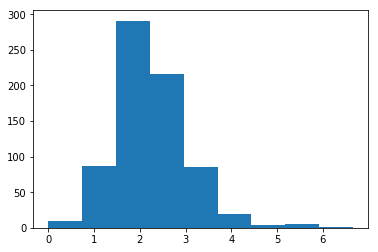

In [17]:
plt.hist(y,bins)

In [18]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
est.fit(y.reshape(-1,1))
ynew = est.transform(y.reshape(-1,1))
np.unique(ynew,return_counts=True)

(array([0., 1., 2.]), array([240, 239, 240]))

In [19]:
y = ynew

In [20]:
l,n = X.shape

x0 = np.ones(l)
x0[X[:,0] == 'Female'] = -1.

np.unique(x0,return_counts=True)

(array([-1.,  1.]), array([365, 354]))

In [21]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
x1 = onehot_encoder.fit_transform(X[:,1].reshape(-1,1))

x1.shape

(719, 4)

In [22]:
x2 = X[:,2].astype(float)

In [23]:
X = np.hstack([x0[:,np.newaxis],x1,x2[:,np.newaxis]])
X.shape

(719, 6)

In [24]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [25]:
from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [26]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=100,regu=0.)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(multi_class='multinomial',solver='saga')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [27]:
def compare_inference(X,y,train_size):
    npred = 5
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        #X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)

        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [28]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

0.8 [0.45       0.45694444 0.45277778 0.44305556]


/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

0.6 [0.46944444 0.45972222 0.45833333 0.45833333]


/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

0.4 [0.4375     0.42222222 0.44444444 0.43888889]


/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/tai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

0.2 [0.43333333 0.42916667 0.42777778 0.43194444]


In [29]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,expectation_reflection
0,0.8,0.450000,0.456944,0.452778,0.443056
1,0.6,0.469444,0.459722,0.458333,0.458333
2,0.4,0.437500,0.422222,0.444444,0.438889
3,0.2,0.433333,0.429167,0.427778,0.431944


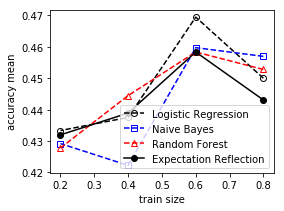

In [30]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
#plt.plot(list_train_size,acc[:,3],'b--',label='Decision Tree')
plt.plot(list_train_size,acc[:,-1],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy mean')
plt.legend()